## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)# setting the seed for same answers as the classroom quizzes

`1.` a. Read in the dataset and take a look at the top few rows here:

In [2]:
df= pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset:

In [3]:
overall_users=df.shape[0]
overall_users
#We have 294478 rows in this dataset.  

294478

c. The number of unique users in the dataset:

In [4]:
df['user_id'].nunique()
# We have 290584 unique users.

290584

d. The proportion of users converted:

In [5]:
df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

In [6]:
converted_users=df.query('converted==1')['user_id'].nunique()
proportion=round(converted_users*(100/(overall_users)),2)
print('Only '+ str(converted_users) +' users converted which represents '+str(proportion)+'%')

Only 35173 users converted which represents 11.94%


e. The number of times the `new_page` and `treatment` don't line up:

In [7]:
df.query('(landing_page == "new_page" and group!= "treatment") or (landing_page != "new_page" and group == "treatment")')['user_id'].count()
#The number of times the new_page and treatment don't match is 3893. 

3893

f. Th number of rows with missing values(if any):

In [8]:
df.isnull().sum().any()
#We dont have any missing values.

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. The new **df2** without these rows:

In [9]:
#We are now removing the rows where the new_page and treatment don't match.
df2=df.drop(df.query('(landing_page == "new_page" and group!= "treatment") or (landing_page != "new_page" and group == "treatment")').index)

In [10]:
# This should be 0 since all relevant rows were removed .
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`a. The number of unique **user_id**s in **df2**:

In [11]:
df2['user_id'].nunique()
#We have 290584 unique user_id in df2 now.

290584

b&c. The repeated **user_id** in **df2** and its row information:

In [12]:
df2[df2.duplicated(['user_id'],keep=False)]
# The repeated user_id is 773192. 
#Only the timestamp column differs in the two rows otherwise the remaining information is the same.

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Dropping one of the repeated row from **df2**:

In [13]:
df2=df2.drop(df2[(df2.user_id==773192) & (df2.timestamp=='2017-01-14 02:55:59.590927') ].index)
df2[df2['user_id']==773192]
#We dropped the row with index 2893.

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Let now start calculating the probablities.
a. The probability of an individual converting regardless of the page they receive:

In [14]:
converted_users2=df2.query('converted==1')['user_id'].nunique()
converted_prob2=round(converted_users2/df2.shape[0],4)
print( 'The probability of converting regardless of page is '+str(converted_prob2)+' .')

The probability of converting regardless of page is 0.1196 .


b. Given that an individual was in the `control` group, the probability they converted:

In [15]:
converted_control_users2=df2.query('converted==1 and group =="control"')['user_id'].nunique()
control_users2=df2.query('group =="control"')['user_id'].nunique()
prob_control2=round(converted_control_users2/control_users2,4)
print('Given that an individual was in the control group, the probability of converting is '+str(prob_control2)+' .')

Given that an individual was in the control group, the probability of converting is 0.1204 .


c. Given that an individual was in the `treatment` group, the probability they converted:

In [16]:
converted_treat_users2=df2.query('converted==1 and group =="treatment"')['user_id'].nunique()
treat_users2=df2.query('group =="treatment"')['user_id'].nunique()
prob_treat2=round(converted_treat_users2/treat_users2,4)
print('Given that an individual was in the treatment group, the probability of converting is '+str(prob_treat2)+' .')

Given that an individual was in the treatment group, the probability of converting is 0.1188 .


d. The probability that an individual received the new page:

In [17]:
newpage_users= df2.query('landing_page=="new_page"')['user_id'].nunique()
prob_newpage2=round(newpage_users/df2.shape[0],4)
print('The probability of receiving the new page is '+str(prob_newpage2)+' .')

The probability of receiving the new page is 0.5001 .


e. Observation on our results from a through d .

We observe that:

1. The probability of converting regardless of page is 0.1196 .

2. Given that an individual was in the control group, the probability of converting is 0.1204 .

3. Given that an individual was in the treatment group, the probability of converting is 0.1188 .

>We are getting approximately the same probability regardless wherether we are in the control or treatement group which explain why our overall conversion propability regardless of the page is ~0.12 too.We conclude that there isnt sufficient evidence to say that the new treatment page leads to more conversions.


<a id='ab_test'></a>
### Part II - A/B Test

We notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, please see below our null and alternative hypotheses in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> Null Hypothese $H_{0}$: $p_{new}$ <= $p_{old}$

> Alternative Hypothese $H_{1}$: $p_{new}$ > $p_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

We will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. The **convert rate** for $p_{new}$ under the null:

In [18]:
p_new=round(df2.query('converted==1')['user_id'].nunique()/df2.shape[0],4)
p_new

0.1196

b. The **convert rate** for $p_{old}$ under the null: <br><br>

In [19]:
p_old=round(df2.query('converted==1')['user_id'].nunique()/df2.shape[0],4)
p_old

#Please note we were already aware here that p_old & p_new were equal.

0.1196

c. The value for $n_{new}$:

In [20]:
#Unique users with the new page
n_new=df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. The value for $n_{old}$:

In [21]:
#Unique users with the old page
n_old=df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

e. We will simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null and then store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted =np.random.choice([0,1],n_new,p=(p_new,1-p_new))
new_page_converted

array([1, 0, 0, ..., 1, 1, 1])

f. We will simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null and then store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted =np.random.choice([0,1],n_old,p=(p_old,1-p_old))
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

g. We will compute $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [24]:
new_page_converted.mean()-old_page_converted.mean()
#p_new - p_old under the null is ~0.

-0.0006376960633270867

h. We will simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one we calculated in parts **a. through g.** above and then store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
# Create sampling distribution for difference in completion rates with boostrapping
p_diffs = []
size = df.shape[0]
for _ in range(10000):
    samp = df2.sample(size, replace=True)
    new_page_converted =np.random.choice([0,1],n_new,p=(p_new,1-p_new))
    old_page_converted =np.random.choice([0,1],n_old,p=(p_old,1-p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())   

In [26]:
p_diffs=np.array(p_diffs) 

i. The histogram of the **p_diffs**:

(array([   4.,   61.,  369., 1339., 2544., 2794., 2019.,  686.,  164.,
          20.]),
 array([-0.00478142, -0.00387084, -0.00296026, -0.00204967, -0.00113909,
        -0.00022851,  0.00068207,  0.00159265,  0.00250323,  0.00341381,
         0.00432439]),
 <a list of 10 Patch objects>)

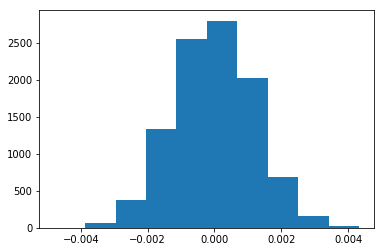

In [27]:
plt.hist(p_diffs)
# This plot is what we expected so we can support our null.

j. The proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**:

In [28]:
#computing actual observed difference based on actual converted rate
convert_new=(df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique())/n_new
convert_old=(df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique())/n_old
observed_diff=convert_new-convert_old
observed_diff

-0.0015782389853555567

(array([  18.,  138.,  611., 1764., 2723., 2619., 1511.,  503.,  105.,
           8.]),
 array([-4.38136204e-03, -3.49140652e-03, -2.60145100e-03, -1.71149548e-03,
        -8.21539958e-04,  6.84155626e-05,  9.58371084e-04,  1.84832660e-03,
         2.73828213e-03,  3.62823765e-03,  4.51819317e-03]),
 <a list of 10 Patch objects>)

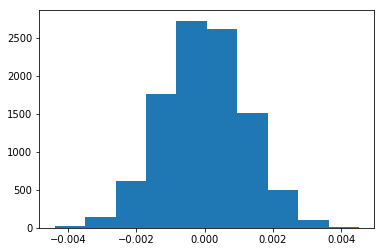

In [29]:
# create distribution under the null hypothesis and plot it
dist_under_H0=np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(dist_under_H0)

In [30]:
(dist_under_H0 > observed_diff).mean()

0.9043

k. Obervation on part **j.** :

> We just computed the p-value. The p-value is the probability of getting our statistic or a more extreme value if the null is true.

> We observe that $p_{old}$  > $alpha$ with Type I error rate of 5% so we fail to reject $H_{0}$ . 

> We conclude that the probability of convert rate for the old page is the same as the new page with a 5% Type I error rate.

l. We could also use a built-in to achieve similar results per below.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [31]:
import statsmodels.api as sm

convert_old,convert_new,n_old,n_new

(0.1203863045004612, 0.11880806551510564, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [32]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
z_score, p_value

(-0.0032875796753531767, 0.5013115521701044)

In [33]:
from scipy.stats import norm

norm.cdf(z_score) # the significance of our z-score

0.49868844782989563

In [34]:
norm.ppf(1-(0.05/2))# our critical value at 95% confidence

1.959963984540054

n. Observation on z-score and p-value computed.

>We observe that the z-score is lower than the critical value of ~1.96 so we fail to reject $H_{0}$ .

>We conclude that the conversion rates of the old and new pages are the same which agrees with our finding in parts **j.** and **k.** .

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Type of regression better suited for our case:

> We have here categorical variable so we should be performing a logistic regression.

> Logistic Regression is a predictive multiple regression outproach used when the dependent variable is binary.It describes data and explains the relationship between one dependent binary variable and one or more independent variables.

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  We will add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept'] = 1

In [36]:
df2= df2.join(pd.get_dummies(df2['landing_page']))

In [37]:
df2['ab_page'] = pd.get_dummies(df2['group']) ['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


c. We will use **statsmodels** to import your regression model. We will then instantiate the model, and fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [38]:
logit_mod1 = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

d. The summary of our model below:

In [39]:
results1 = logit_mod1.fit()
print(results1.summary())

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 11 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        23:36:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.

e. The p-value associated with **ab_page**:

>The p-value associated with ab_page is 0.190 .

>In my regression model, $H_{0}$  is that there is no difference between the treatment and control group and $H_{1}$  is that there is a difference between the two groups.

>In part II, we have mentioned that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%,which wasnt the case here in our regression model. We have used different explanatory variable in both parts which is the reason behind the difference in p_value.

f. Now, we are considering other things that might influence whether or not an individual converts.

>We may try to add the influences associated with time(timestamp variable) on conversion. We can explore whether the conversion rate depends on on a specific time or day in the week where people tend to look through the website. We can convert this field into a categorical field where we will have only four aspects of time (Morning,Afternoon,Evening and Night).

>Please note that adding more terms will make our model more complex and take away the ease of interpreting coefficients. We could also experience seeing some of the new terms dependable on the independent variable  which would require higher order terms to improve the performance of our model.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together our datasets on the approporiate rows.

In [40]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [41]:
countries_df['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [42]:
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US,CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [43]:
df_new = df_new.drop('CA',axis=1)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [44]:
df_new['intercept'] = 1
logit_mod2 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK','US']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 11 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        23:36:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [45]:
np.exp(-0.0150),np.exp(0.0506),np.exp(0.0408)

(0.9851119396030626, 1.0519020483004984, 1.0416437559600236)

In [46]:
1/np.exp(-0.0150)

1.015113064615719

We observe that:

1. For each 1 unit decrease in new_page, convert is ~1.02 times more likely to happen, holding all other varible constant.

2. For each 1 unit increase in UK, convert is ~1.05 times more likely to happen, holding all other varible constant.

3. For each 1 unit increase in US, convert is ~1.04 times more likely to happen, holding all other varible constant.

> We conclude that countries dont have an impact on conversion rate.

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if it has significant effect on conversion.

In [47]:
#Create a new intereacton variable between new page and US&UK
df_new['UK_new_page'] = df_new['new_page']* df_new['UK']
df_new['US_new_page'] = df_new['new_page']* df_new['US']

#Create logistic regression for the interaction variable between new page and country using dummy variable
logit_mod3 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK_new_page','US_new_page','UK','US']])
results3 = logit_mod3.fit()
results3.summary()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 11 Oct 2020   Pseudo R-squ.:               3.482e-05
Time:                        23:36:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9865      0.010   -206.344      0.000      -2.005      -1.968
new_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK_new_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
US_new_page     0.0314      0.027      1.181      0.238      -0.021       0.084
UK             -0.0175      0.038     -0.465      0.642      -0.091       0.056
US             -0.0057      0.019     -0.306      0.760      -0.043       0.031
===============================================================================
"""

In [48]:
np.exp(results3.params)

intercept      0.137178
new_page       0.979646
UK_new_page    0.954198
US_new_page    1.031896
UK             0.982625
US             0.994272
dtype: float64

We observe from the above results that :

1. We can see the coefficients for **UK_new_page** and **US_new_page** are different from the coefficient of **new_page**.

2. Only intercept's p-value=0 is less than 0.05, which is statistically significant enough for converted rate. Other variables in the summary are not statistically significant. 

3. Z-score for all X variables are not large enough to be significant for predicting converted rate. 

4. For each 1 unit increase in new_page, convert is ~0.93 times more likely to happen, holding all other varible constant.

> We conclude that the country a user lives in is not significant on the converted rate considering the page the user land in. 


# Extra - Model Diagnostics section

In [49]:
#Import sklearn model to split, test and score data,and fit data model 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [50]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US,UK_new_page,US_new_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0,1


In [51]:
#Define X and Y variable 
x = df_new[['new_page','UK_new_page','US_new_page','UK','US']]
y = df_new['converted']
        
#Split data into train and test data then fit the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

logit_mod4=LinearRegression()
logit_mod4.fit(X_train,y_train) 
print (logit_mod4.score(X_train,y_train) )

# The score result or the coefficient of determination R^2 of the prediction is very low, 
#which mean the page and country dataset are not a good fit to predit converted rate .

# Please note that it is meaningless here to try to use a classification metric (accuracy) 
#in a regression (i.e. numeric prediction) model.It will give an error for this
#theoretical and not computational issue when you try running the below code and importing the relevant library.
#from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
#y_preds = logit_mod4.predict()
#print(accuracy_score(y_te))


2.2826081036986245e-05


<a id='conclusions'></a>
## Conclusions

>In part I, we were first making use of simple probabilities and we observed approximately the same probability regardless wherether we are in the control or treatement group which explain why our overall conversion propability regardless of the page is ~0.12 too so we concluded that there isnt sufficient evidence to say that the new treatment page leads to more conversions.

>In part II, we decided to implement an A/B test and we observed that $p_{old}$ > $alpha$ with Type I error rate of 5%  and the z-score is lower than the critical value of ~1.96 so we failed to reject H0 ($p_{new}$ <= $p_{old}$) and we concluded that the conversion rates of the old and new pages are the same.

>In part III, we decided to implement a logistic regression model on the dataset where we failed again to reject the null. We also added another effect based on which country a user lives onto our regression model and concluded that the country is not significant on the converted rate considering the page the user land on. 

>To go above and beyond, we may try to add the influences associated with time(timestamp variable) on conversion as previously mentioned where 4 dummy variables would be created for different aspects of the time (Morning,Afternoon,Evening and Night). Correctly implementing and interpreting the results would be good for our analysis. However, we should keep in mind that adding more terms to our model other than time will make it more complex, take away the ease of interpreting coefficients and might require high order terms if the new terms are dependable on the independent variable .
